In [109]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import yaml
import json
from tqdm import tqdm
from datetime import datetime
from typing import Dict, List, Tuple
import argparse
import warnings

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns

warnings.filterwarnings('ignore')

# Setup device and reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")


Device: cuda
PyTorch version: 2.0.1


In [110]:
class Config:
    """Configuration class for evaluation parameters"""
    def __init__(self):
        # Model parameters
        self.num_layers = 1
        self.hidden_dim = 128
        self.batch_size = 1
        
        # Training parameters
        self.epochs = 600
        self.opt = 'adam'
        self.lr = 0.0001
        self.weight_decay = 5e-4
        
        # Data parameters
        self.num_segments = 1
        self.min_length = 60
        self.time_step = 0.1
        self.train_size = 30
        self.test_size = 5
        
        # Directories
        self.checkpoint_dir = './checkpoints/'
        self.log_dir = './logs/'
        self.data_dir = './'
        
        # Other
        self.version = 'v1'
        self.device = 'auto'
        self.resume = False
        self.log_interval = 10

# Create configuration instance
args = Config()

# Device setup
if args.device == 'auto':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device(args.device)

print(f"Configuration loaded successfully")
print(f"Device: {device}")

Configuration loaded successfully
Device: cuda


In [111]:
# Import model components
import importlib
import sys

# Clear any cached modules
modules_to_reload = [key for key in sys.modules.keys() if key.startswith('models')]
for module in modules_to_reload:
    if module in sys.modules:
        del sys.modules[module]

try:
    from models import MeshODENet
    print("Model components imported successfully")
except ImportError as e:
    print(f"Import error: {e}")
    print("Please ensure models module is available and properly installed")
    raise

print("Model components loaded")

Model components imported successfully
Model components loaded


In [112]:
def load_data_and_stats(args):
    """Load test data and statistics using config paths"""
    processed_dir = os.path.join(args.data_dir, 'processed_dataset')
    # Load data
    train_data = torch.load(os.path.join(processed_dir, 'train.pt'))
    test_data = torch.load(os.path.join(processed_dir, 'test.pt'))
    stats = torch.load(os.path.join(processed_dir, 'stats_train.pt'))
    
    print(f"Loaded {len(train_data)} training trajectories")
    print(f"Loaded {len(test_data)} test trajectories")
    print(f"Statistics keys: {list(stats.keys())}")
    
    # Move stats to device
    stats = {key: value.to(device) if isinstance(value, torch.Tensor) else value 
             for key, value in stats.items()}
    
    return train_data, test_data, stats

train_data, test_data, stats = load_data_and_stats(args)


Loaded 30 training trajectories
Loaded 6 test trajectories
Statistics keys: ['vel_mean', 'vel_std', 'youngs_mean', 'youngs_std', 'edge_mean', 'edge_std', 'mesh_edge_mean', 'mesh_edge_std', 'node_size', 'edge_size']


In [113]:
# Model loading and initialization

def find_best_checkpoint(checkpoint_dir):
    """Find the best or latest checkpoint in the directory"""
    if not os.path.exists(checkpoint_dir):
        return None
    
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]
    if not checkpoint_files:
        return None
    
    # Sort by modification time to get the latest
    checkpoint_files.sort(key=lambda x: os.path.getmtime(os.path.join(checkpoint_dir, x)), reverse=True)
    
    return os.path.join(checkpoint_dir, checkpoint_files[0])

def load_trained_model(model_path,args,stats):
    """Load pre-trained model from checkpoint"""
    num_classes = 3  # Velocity dimension
    model = MeshODENet(
        hidden_dim=args.hidden_dim,
        output_dim=num_classes,
        node_size=stats['node_size'].item(),
        edge_size=stats['edge_size'].item(),
        num_layers=args.num_layers
    ).to(device)

    try:
        model.load_state_dict(torch.load(model_path))
        model.eval()
        return model
    except:
        raise FileNotFoundError("No model found.")

def find_model_with_priority(args):
    """Find model with priority: 1) best_model.pt 2) latest checkpoint"""
    model_name = (f"MeshODENet_nl{args.num_layers}_bs{args.batch_size}_"
                 f"hd{args.hidden_dim}_ep{args.epochs}_wd{args.weight_decay}_"
                 f"lr{args.lr}_seg{args.num_segments}_v{args.version}")
    print(f"Model name: {model_name}")
    try:
        model_path = os.path.join(args.checkpoint_dir, f"{model_name}_best.pt")
        print(f"Found best model: {model_path}")
        return model_path
    except:
        model_path = os.path.join(args.checkpoint_dir, f"{model_name}_checkpoint.pt")
        print(f"Found checkpoint: {model_path}")
        return model_path

model_path = find_model_with_priority(args)

model = load_trained_model(model_path,args,stats)
total_params = sum(p.numel() for p in model.parameters())
print(f"Model loaded successfully")
print(f"Total parameters: {total_params:,}")
print(f"Model configuration:")
print(f"- Hidden dimension: {args.hidden_dim}")
print(f"- Number of layers: {args.num_layers}")

Model name: MeshODENet_nl1_bs1_hd128_ep600_wd0.0005_lr0.0001_seg1_vv1
Found best model: ./checkpoints/MeshODENet_nl1_bs1_hd128_ep600_wd0.0005_lr0.0001_seg1_vv1_best.pt
Model loaded successfully
Total parameters: 249,731
Model configuration:
- Hidden dimension: 128
- Number of layers: 1


In [114]:
# Evaluation metrics computation
class EvaluationMetrics:
    """Comprehensive evaluation metrics for model performance analysis"""
    
    @staticmethod
    def compute_rmse(pred, target):
        """Root Mean Square Error"""
        return torch.sqrt(torch.mean((pred - target) ** 2))
    
    @staticmethod
    def compute_mae(pred, target):
        """Mean Absolute Error"""
        return torch.mean(torch.abs(pred - target))
    
    @staticmethod
    def compute_mse(pred, target):
        """Mean Square Error"""
        return torch.mean((pred - target) ** 2)
    
    @staticmethod
    def compute_position_drift(pred_pos, target_pos):
        """Position drift over time"""
        # Compute cumulative displacement error
        errors = torch.norm(pred_pos - target_pos, dim=-1)  # [time, nodes]
        drift = torch.mean(errors, dim=1)  # Average over nodes for each timestep
        return drift
    
    
    @staticmethod
    def compute_velocity_correlation(pred_vel, target_vel):
        """Velocity direction correlation"""
        pred_vel_flat = pred_vel.reshape(-1, pred_vel.shape[-1])
        target_vel_flat = target_vel.reshape(-1, target_vel.shape[-1])
        
        # Normalize velocities
        pred_norm = pred_vel_flat / (torch.norm(pred_vel_flat, dim=-1, keepdim=True) + 1e-8)
        target_norm = target_vel_flat / (torch.norm(target_vel_flat, dim=-1, keepdim=True) + 1e-8)
        
        # Compute cosine similarity
        correlation = torch.sum(pred_norm * target_norm, dim=-1)
        return torch.mean(correlation)

def evaluate_single_trajectory(model, trajectory, stats, args, time_step_len=None):
    """Evaluate model on a single trajectory"""
    trajectory = {key: value.to(device) if isinstance(value, torch.Tensor) else value 
                 for key, value in trajectory.items()}
    
    if time_step_len is None:
        time_step_len = trajectory['world_pos'].shape[0]
    
    time_step = args.time_step
    t_span = torch.linspace(0, time_step_len - 1, time_step_len)*time_step
    
    # Model prediction
    start_time = time.time()
    with torch.no_grad():
        try:
            pred_pos, pred_vel = model(trajectory, stats, t_span)
        except Exception as e:
            print(f"Model prediction error: {e}")
            raise
    inference_time = time.time() - start_time
    
    # Ground truth
    target_pos = trajectory['world_pos'][:time_step_len]
    target_vel = trajectory['velocity'][:time_step_len]
    
    # Ensure predictions and targets have same shape
    min_steps = min(pred_pos.shape[0], target_pos.shape[0])
    pred_pos = pred_pos[:min_steps]
    pred_vel = pred_vel[:min_steps]
    target_pos = target_pos[:min_steps]
    target_vel = target_vel[:min_steps]
    
    # Compute metrics
    metrics = {
        'position_rmse': EvaluationMetrics.compute_rmse(pred_pos, target_pos).item(),
        'position_mae': EvaluationMetrics.compute_mae(pred_pos, target_pos).item(),
        'position_mse': EvaluationMetrics.compute_mse(pred_pos, target_pos).item(),
        'velocity_rmse': EvaluationMetrics.compute_rmse(pred_vel, target_vel).item(),
        'velocity_mae': EvaluationMetrics.compute_mae(pred_vel, target_vel).item(),
        'velocity_correlation': EvaluationMetrics.compute_velocity_correlation(pred_vel, target_vel).item(),
        'inference_time': inference_time,
        'time_steps': min_steps,
        'original_time_steps': time_step_len
    }
    
    # Position drift over time
    position_drift = EvaluationMetrics.compute_position_drift(pred_pos, target_pos)
    
    return metrics, {
        'pred_pos': pred_pos.cpu().numpy(),
        'pred_vel': pred_vel.cpu().numpy(),
        'target_pos': target_pos.cpu().numpy(),
        'target_vel': target_vel.cpu().numpy(),
        'position_drift': position_drift.cpu().numpy()
    }

print("Evaluation utilities initialized")


Evaluation utilities initialized


In [115]:
def evaluate_test_set(model, test_data, stats, args, one_for_visualization = 0, max_time_step_len = 100, max_trajectories = None):
    """Evaluate model on entire test set"""
    print("\n=== Test Set Evaluation ===")
    print(f"Using time step length: {args.time_step}")
    print(f"Test data size limit: {args.test_size}")
    
    all_metrics = []
    trajectory_results = []
    
    # Limit number of trajectories based on args or parameter
    test_size = args.test_size
    if max_trajectories is not None:
        eval_size = min(max_trajectories, test_size, len(test_data))
    else:
        eval_size = min(test_size, len(test_data))
    
    eval_data = test_data[:eval_size]
    print(f"Evaluating {len(eval_data)} trajectories")
    
    for traj_idx, trajectory in enumerate(tqdm(eval_data, desc="Evaluating trajectories")):
        try:
            metrics, results = evaluate_single_trajectory(model, trajectory, stats, args, time_step_len = max_time_step_len)
            metrics['trajectory_id'] = traj_idx
            all_metrics.append(metrics)
            
            # Store first trajectory results for visualization
            if traj_idx == one_for_visualization:
                trajectory_results = results
                
        except Exception as e:
            print(f"Error evaluating trajectory {traj_idx}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    if not all_metrics:
        raise RuntimeError("No trajectories were successfully evaluated")
    
    # Convert to DataFrame for analysis
    metrics_df = pd.DataFrame(all_metrics)
    
    # Compute summary statistics
    summary_stats = {
        'mean_position_rmse': metrics_df['position_rmse'].mean(),
        'std_position_rmse': metrics_df['position_rmse'].std(),
        'mean_position_mae': metrics_df['position_mae'].mean(),
        'mean_velocity_rmse': metrics_df['velocity_rmse'].mean(),
        'mean_velocity_correlation': metrics_df['velocity_correlation'].mean(),
        'total_inference_time': metrics_df['inference_time'].sum(),
        'avg_inference_time': metrics_df['inference_time'].mean(),
        'num_trajectories': len(metrics_df),
        'avg_time_steps': metrics_df['time_steps'].mean(),
        'model_config': {
            'hidden_dim': args.hidden_dim,
            'num_layers': args.num_layers,
            'time_step_length': args.time_step
        }
    }
    
    # Print summary
    print(f"\nEvaluation Summary ({summary_stats['num_trajectories']} trajectories):")
    print(f"Position RMSE: {summary_stats['mean_position_rmse']:.6f} ± {summary_stats['std_position_rmse']:.6f}")
    print(f"Position MAE:  {summary_stats['mean_position_mae']:.6f}")
    print(f"Velocity RMSE: {summary_stats['mean_velocity_rmse']:.6f}")
    print(f"Velocity Correlation: {summary_stats['mean_velocity_correlation']:.4f}")
    print(f"Average Inference Time: {summary_stats['avg_inference_time']:.3f}s")
    print(f"Average trajectory length: {summary_stats['avg_time_steps']:.1f} steps")
    
    return metrics_df, summary_stats, trajectory_results

# Run comprehensive evaluation
print("Starting comprehensive evaluation...")
metrics_df, summary_stats, sample_trajectory = evaluate_test_set(model, test_data, stats, args, one_for_visualization=0, max_time_step_len=600)

Starting comprehensive evaluation...

=== Test Set Evaluation ===
Using time step length: 0.1
Test data size limit: 5
Evaluating 5 trajectories


Evaluating trajectories: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Evaluation Summary (5 trajectories):
Position RMSE: 0.000814 ± 0.000054
Position MAE:  0.000477
Velocity RMSE: 0.000334
Velocity Correlation: 0.7568
Average Inference Time: 1.045s
Average trajectory length: 400.0 steps


In [116]:
# Save evaluation results for analysis
def save_evaluation_results(metrics_df, summary_stats):
    """Save evaluation results and generate analysis reports"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create results directory
    results_dir = './evaluation_results'
    os.makedirs(results_dir, exist_ok=True)
    
    # Save detailed metrics
    metrics_file = os.path.join(results_dir, f'detailed_metrics_{timestamp}.csv')
    metrics_df.to_csv(metrics_file, index=False)
    
    # Save summary statistics
    summary_file = os.path.join(results_dir, f'summary_stats_{timestamp}.json')
    with open(summary_file, 'w') as f:
        json.dump(summary_stats, f, indent=2)
    
    # Create report-ready summary table
    report_stats = {
        'Metric': ['Position RMSE', 'Position MAE', 'Velocity RMSE',
                  'Velocity Correlation', 'Inference Time (s)'],
        'Mean': [f"{summary_stats['mean_position_rmse']:.6f}",
                f"{summary_stats['mean_position_mae']:.6f}",
                f"{summary_stats['mean_velocity_rmse']:.6f}",
                f"{summary_stats['mean_velocity_correlation']:.4f}",
                f"{summary_stats['avg_inference_time']:.3f}"],
        'Std': [f"{summary_stats['std_position_rmse']:.6f}", '-', '-', '-', '-']
    }
    
    report_df = pd.DataFrame(report_stats)
    report_file = os.path.join(results_dir, f'report_table_{timestamp}.csv')
    report_df.to_csv(report_file, index=False)
    
    print(f"\nResults saved to {results_dir}/")
    print(f"- Detailed metrics: {os.path.basename(metrics_file)}")
    print(f"- Summary statistics: {os.path.basename(summary_file)}")
    print(f"- report table: {os.path.basename(report_file)}")
    
    return results_dir

# Save results
results_dir = save_evaluation_results(metrics_df, summary_stats)

# Display report-ready table
print("\n=== report-Ready Results Table ===")
report_stats = pd.DataFrame({
    'Metric': ['Position RMSE', 'Position MAE', 'Velocity RMSE',
               'Velocity Correlation', 'Inference Time (s)'],
    'Value': [f"{summary_stats['mean_position_rmse']:.6f} ± {summary_stats['std_position_rmse']:.6f}",
              f"{summary_stats['mean_position_mae']:.6f}",
              f"{summary_stats['mean_velocity_rmse']:.6f}",
              f"{summary_stats['mean_velocity_correlation']:.4f}",
              f"{summary_stats['avg_inference_time']:.3f}"]
})
print(report_stats.to_string(index=False))



Results saved to ./evaluation_results/
- Detailed metrics: detailed_metrics_20250726_111805.csv
- Summary statistics: summary_stats_20250726_111805.json
- report table: report_table_20250726_111805.csv

=== report-Ready Results Table ===
              Metric               Value
       Position RMSE 0.000814 ± 0.000054
        Position MAE            0.000477
       Velocity RMSE            0.000334
Velocity Correlation              0.7568
  Inference Time (s)               1.045



=== Generating Visualizations ===


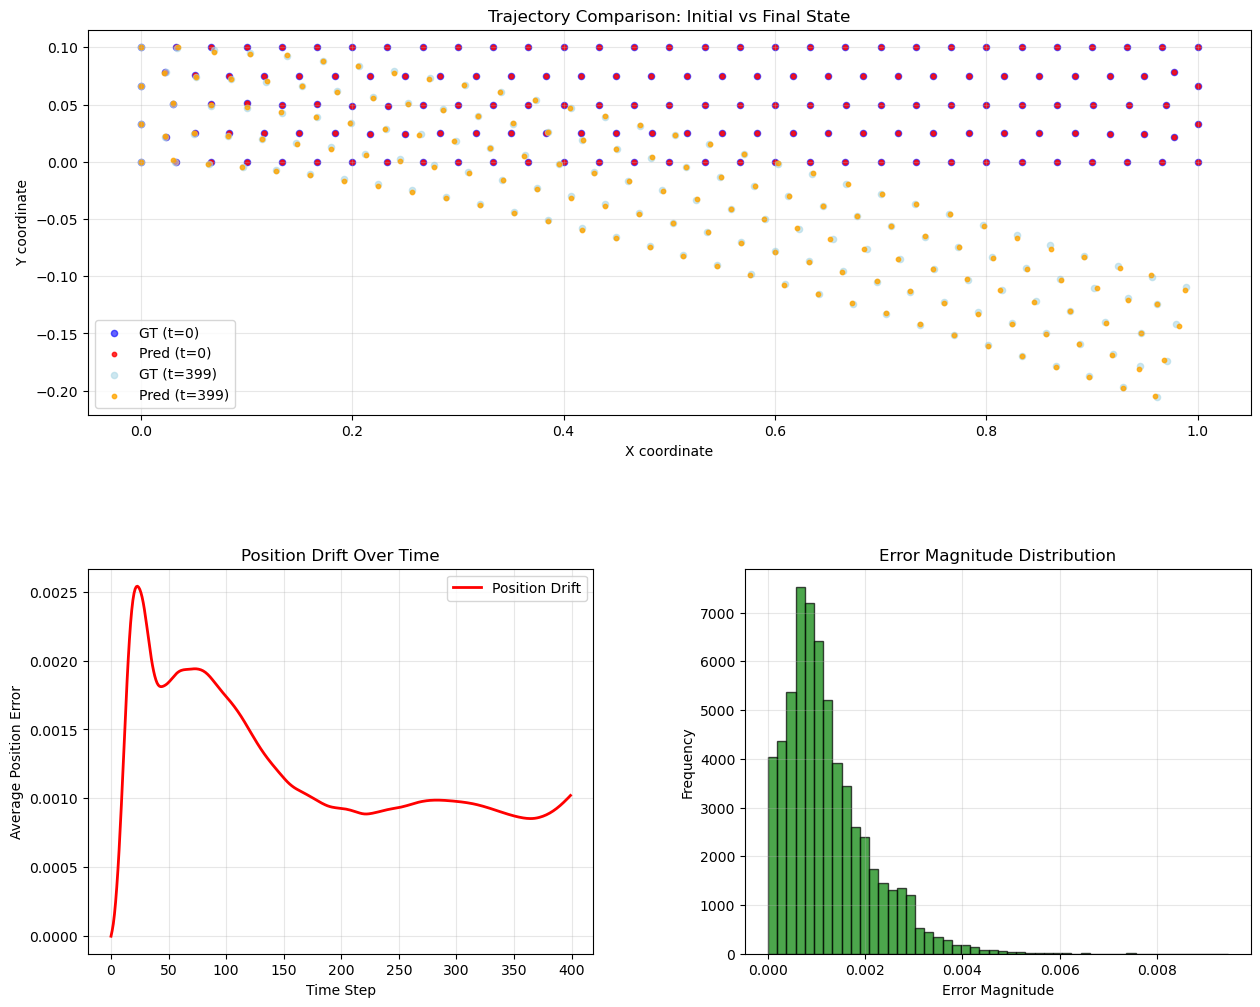

In [117]:
# Visualization functions
def plot_trajectory_comparison(sample_trajectory):
    """Plot trajectory comparison for selected sample"""
    pred_pos = sample_trajectory['pred_pos']
    target_pos = sample_trajectory['target_pos']
    position_drift = sample_trajectory['position_drift']
    
    # Set up a layout: one wide plot on top, two plots below
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.4, wspace=0.3)
    ax_top = fig.add_subplot(gs[0, :])
    ax_bl  = fig.add_subplot(gs[1, 0])
    ax_br  = fig.add_subplot(gs[1, 1])
    axes = np.array([[ax_top, None], [ax_bl, ax_br]], dtype=object)

    # Top: initial vs final trajectory
    ax_top.scatter(target_pos[0, :, 0], target_pos[0, :, 1],
                   c='blue',  s=20, alpha=0.6, label='GT (t=0)')
    ax_top.scatter(pred_pos[0,  :, 0], pred_pos[0,  :, 1],
                   c='red',   s=10, alpha=0.8, label='Pred (t=0)')
    final_step = len(pred_pos) - 1
    ax_top.scatter(target_pos[final_step, :, 0], target_pos[final_step, :, 1],
                   c='lightblue', s=20, alpha=0.6, label=f'GT (t={final_step})')
    ax_top.scatter(pred_pos[final_step, :, 0], pred_pos[final_step, :, 1],
                   c='orange',    s=10, alpha=0.8, label=f'Pred (t={final_step})')
    ax_top.set_xlabel('X coordinate')
    ax_top.set_ylabel('Y coordinate')
    ax_top.set_title('Trajectory Comparison: Initial vs Final State')
    ax_top.legend()
    ax_top.grid(True, alpha=0.3)
    
    # Position drift over time
    time_steps = np.arange(len(position_drift))
    axes[1, 0].plot(time_steps, position_drift, 'r-', linewidth=2, label='Position Drift')
    axes[1, 0].set_xlabel('Time Step')
    axes[1, 0].set_ylabel('Average Position Error')
    axes[1, 0].set_title('Position Drift Over Time')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # Error magnitude distribution
    error_magnitude = np.linalg.norm(pred_pos - target_pos, axis=-1)
    axes[1, 1].hist(error_magnitude.flatten(), bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 1].set_xlabel('Error Magnitude')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Error Magnitude Distribution')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'trajectory_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Generate visualizations
print("\n=== Generating Visualizations ===")
plot_trajectory_comparison(sample_trajectory)


In [118]:
# Create animation for selected trajectory
def create_trajectory_animation(sample_trajectory, save_animation=True):
    """Create animated visualization of trajectory evolution"""
    pred_pos = sample_trajectory['pred_pos']
    target_pos = sample_trajectory['target_pos']
    
    # Subsample for animation performance
    animation_steps = min(100, len(pred_pos))
    step_interval = len(pred_pos) // animation_steps
    
    pred_anim = pred_pos[::step_interval]
    target_anim = target_pos[::step_interval]
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Determine plot bounds
    all_pos = np.concatenate([pred_anim.reshape(-1, pred_anim.shape[-1]), 
                             target_anim.reshape(-1, target_anim.shape[-1])])
    x_min, x_max = all_pos[:, 0].min() - 0.1, all_pos[:, 0].max() + 0.1
    y_min, y_max = all_pos[:, 1].min() - 0.1, all_pos[:, 1].max() + 0.1
    
    def animate(frame):
        ax.clear()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
        ax.set_title(f'Trajectory Evolution - Step {frame * step_interval}')
        
        # Plot ground truth
        ax.scatter(target_anim[frame, :, 0], target_anim[frame, :, 1], 
                  c='blue', s=25, alpha=0.7, label='Ground Truth', marker='o')
        
        # Plot prediction
        ax.scatter(pred_anim[frame, :, 0], pred_anim[frame, :, 1], 
                  c='red', s=15, alpha=0.9, label='Prediction', marker='x')
        
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
    
    # Create animation
    anim = FuncAnimation(fig, animate, frames=len(pred_anim), interval=200, repeat=True)
    
    if save_animation:
        try:
            animation_path = os.path.join(results_dir, 'trajectory_evolution.mp4')
            anim.save(animation_path, writer='ffmpeg', fps=5, bitrate=1800)
            print(f"Animation saved: {animation_path}")
        except Exception as e:
            print(f"Could not save animation: {e}")
            print("You may need to install ffmpeg or use HTML5 video instead")
    
    # Return HTML5 video for notebook display
    plt.close(fig)  # Close the figure to prevent display
    return HTML(anim.to_html5_video())

# Create and display animation
print("\n=== Creating Trajectory Animation ===")
animation_html = create_trajectory_animation(sample_trajectory, save_animation=True)
animation_html



=== Creating Trajectory Animation ===
Animation saved: ./evaluation_results/trajectory_evolution.mp4


In [119]:
# Final summary and export
def generate_final_report(args, model, summary_stats, results_dir, model_path, metrics_df):
    """Generate final evaluation report"""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Get model info
    total_params = sum(p.numel() for p in model.parameters())
    model_config = summary_stats['model_config']
    
    report = f"""
# MeshODENet Evaluation Report
Generated: {timestamp}

## Model Configuration
- Model Path: {os.path.basename(model_path)}
- Hidden Dimension: {model_config['hidden_dim']}
- Number of Layers: {model_config['num_layers']}
- Total Parameters: {total_params:,}
- Time Step Length: {model_config['time_step_length']}

## Training Configuration  
- Learning Rate: {args.lr}
- Weight Decay: {args.weight_decay}
- Optimizer: {args.opt}
- Time Step: {args.time_step}

## Data Configuration
- Test Data Size: {args.test_size}
- Train Data Size: {args.train_size}
- Evaluated Trajectories: {summary_stats['num_trajectories']}
- Average Trajectory Length: {summary_stats['avg_time_steps']:.1f} steps

## Evaluation Results
- Position RMSE: {summary_stats['mean_position_rmse']:.6f} ± {summary_stats['std_position_rmse']:.6f}
- Position MAE: {summary_stats['mean_position_mae']:.6f}
- Velocity RMSE: {summary_stats['mean_velocity_rmse']:.6f}
- Velocity Correlation: {summary_stats['mean_velocity_correlation']:.4f}
- Average Inference Time: {summary_stats['avg_inference_time']:.3f}s
- Total Evaluation Time: {summary_stats['total_inference_time']:.2f}s

## Performance Analysis
- Best Trajectory RMSE: {min([m['position_rmse'] for m in metrics_df.to_dict('records')]):.6f}
- Worst Trajectory RMSE: {max([m['position_rmse'] for m in metrics_df.to_dict('records')]):.6f}
- RMSE Standard Deviation: {summary_stats['std_position_rmse']:.6f}

## Files Generated
- Detailed metrics: detailed_metrics_*.csv
- Summary statistics: summary_stats_*.json
- Paper table: paper_table_*.csv
- Metrics visualization: metrics_distribution.png
- Trajectory analysis: trajectory_analysis.png
- Animation: trajectory_evolution.mp4

## Notes
- Evaluation conducted on MeshODENet model
- All metrics computed in original (unnormalized) units
- Animations subsampled for performance
- Version: {args.version}
"""
    
    report_path = os.path.join(results_dir, 'evaluation_report.md')
    with open(report_path, 'w') as f:
        f.write(report)
    
    print("\n=== Final Evaluation Report ===")
    print(report)
    print(f"\nComplete report saved: {report_path}")
    
    return report_path

# Generate final report
report_path = generate_final_report(args, model, summary_stats, results_dir, model_path, metrics_df)

print("\n=== Evaluation Complete ===")
print(f"All results saved to: {os.path.abspath(results_dir)}")
print("\nKey findings:")
print(f"- Best trajectory prediction RMSE: {metrics_df['position_rmse'].min():.6f}")
print(f"- Worst trajectory prediction RMSE: {metrics_df['position_rmse'].max():.6f}")
print(f"- Mean velocity correlation: {summary_stats['mean_velocity_correlation']:.4f}")
print(f"- Total evaluation time: {summary_stats['total_inference_time']:.2f}s")
print(f"- Model file: {os.path.basename(model_path)}")
print(f"- Version: {args.version}")

# Display final metrics summary table
print("\n=== Performance Metrics Summary ===")
final_metrics = pd.DataFrame({
    'Metric': ['Position RMSE', 'Position MAE', 'Velocity RMSE', 'Velocity Correlation', 'Inference Time (ms/step)'],
    'Value': [
        f"{summary_stats['mean_position_rmse']:.6f}",
        f"{summary_stats['mean_position_mae']:.6f}",
        f"{summary_stats['mean_velocity_rmse']:.6f}",
        f"{summary_stats['mean_velocity_correlation']:.4f}",
        f"{summary_stats['avg_inference_time']*1000/summary_stats['avg_time_steps']:.2f}"
    ],
    'Std': [
        f"±{summary_stats['std_position_rmse']:.6f}",
        '-', '-', '-', '-'
    ]
})
print(final_metrics.to_string(index=False))


=== Final Evaluation Report ===

# MeshODENet Evaluation Report
Generated: 2025-07-26 11:18:15

## Model Configuration
- Model Path: MeshODENet_nl1_bs1_hd128_ep600_wd0.0005_lr0.0001_seg1_vv1_best.pt
- Hidden Dimension: 128
- Number of Layers: 1
- Total Parameters: 249,731
- Time Step Length: 0.1

## Training Configuration  
- Learning Rate: 0.0001
- Weight Decay: 0.0005
- Optimizer: adam
- Time Step: 0.1

## Data Configuration
- Test Data Size: 5
- Train Data Size: 30
- Evaluated Trajectories: 5
- Average Trajectory Length: 400.0 steps

## Evaluation Results
- Position RMSE: 0.000814 ± 0.000054
- Position MAE: 0.000477
- Velocity RMSE: 0.000334
- Velocity Correlation: 0.7568
- Average Inference Time: 1.045s
- Total Evaluation Time: 5.23s

## Performance Analysis
- Best Trajectory RMSE: 0.000756
- Worst Trajectory RMSE: 0.000872
- RMSE Standard Deviation: 0.000054

## Files Generated
- Detailed metrics: detailed_metrics_*.csv
- Summary statistics: summary_stats_*.json
- Paper table: pa